Over Sampling+FE+Forward_Feature_Selection+Standardization+Model

1. Import necessary Libraries

In [4]:
#For computational and random seed purpose
import numpy as np
np.random.seed(42)
#to read csv file
import pandas as pd
#To split into train and cv data
from sklearn.model_selection import train_test_split
#To compute AUROC
from sklearn.metrics import auc,roc_auc_score
#for AUROC graph
import matplotlib.pyplot as plt
#for oversampling technique
from imblearn.over_sampling import SMOTE # (https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)
#Data is imbalanced, we need calibrated model
from sklearn.calibration import CalibratedClassifierCV
#for hyperparameter tuning and Cross-validation fold
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RepeatedStratifiedKFold
#to ignore the error message
import warnings
warnings.filterwarnings("ignore")
#for heatmap and other plotting technique
import seaborn as sns
#to strandize the real value data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
#To create Knn model on datasets
from sklearn.neighbors import KNeighborsClassifier
#for roc_curve
from sklearn.metrics import roc_curve,roc_auc_score,accuracy_score

#import eli5
#from eli5.sklearn import PermutationImportance
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from scipy.stats import kurtosis
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')
from catboost import CatBoostClassifier
from sklearn.preprocessing import RobustScaler

In [5]:
#locate parent directory
data_dir = "./"

#Read the training data
df_train = pd.read_csv('train.csv')
print(df_train)


      id  target      0      1      2  ...    295    296    297    298    299
0      0     1.0 -0.098  2.165  0.681  ... -2.097  1.051 -0.414  1.038 -1.065
1      1     0.0  1.081 -0.973 -0.383  ... -1.624 -0.458 -1.099 -0.936  0.973
2      2     1.0 -0.523 -0.089 -0.348  ... -1.165 -1.544  0.004  0.800 -1.211
3      3     1.0  0.067 -0.021  0.392  ...  0.467 -0.562 -0.254 -0.533  0.238
4      4     1.0  2.347 -0.831  0.511  ...  1.378  1.246  1.478  0.428  0.253
..   ...     ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
245  245     0.0 -1.199  0.466 -0.908  ... -0.243  0.525  0.281 -0.255 -1.136
246  246     0.0  0.237  0.233 -0.380  ...  1.004 -0.979  0.007  0.112 -0.558
247  247     0.0  1.411 -1.465  0.119  ... -0.727  0.461  0.760  0.168 -0.719
248  248     1.0  0.620  1.040  0.184  ...  0.478 -0.910 -0.805  2.029 -0.423
249  249     0.0  0.489  0.403  0.139  ...  0.812  0.269 -1.454 -0.625  1.474

[250 rows x 302 columns]


In [6]:
#Read test data
df_test = pd.read_csv('test.csv')
df_test

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,250,0.500,-1.033,-1.595,0.309,-0.714,0.502,0.535,-0.129,-0.687,1.291,0.507,-0.317,1.848,-0.232,-0.340,-0.051,0.804,0.764,1.860,0.262,1.112,-0.491,-1.039,-0.492,0.183,-0.671,-1.313,0.149,0.244,1.072,-1.003,0.832,-1.075,1.988,1.201,-2.065,-0.826,-0.016,0.490,...,0.824,0.928,1.372,1.505,0.645,0.641,-1.132,1.009,0.998,0.210,-1.634,1.046,0.114,-0.806,0.301,0.145,-0.684,0.794,-0.290,-1.688,0.313,1.140,0.447,-0.616,1.294,0.785,0.453,1.550,-0.866,1.007,-0.088,-2.628,-0.845,2.078,-0.277,2.132,0.609,-0.104,0.312,0.979
1,251,0.776,0.914,-0.494,1.347,-0.867,0.480,0.578,-0.313,0.203,1.356,-1.086,0.322,0.876,-0.563,-1.394,0.385,1.891,-2.107,-0.636,-0.055,-0.843,0.041,0.253,0.557,0.475,-0.839,-1.146,1.210,1.427,0.347,1.077,-0.194,0.323,0.543,0.894,1.190,0.342,-0.858,0.756,...,-1.791,0.122,-0.669,-1.558,-0.244,2.583,-0.829,0.133,-2.746,0.341,-1.145,0.492,0.437,-0.628,0.271,2.639,0.481,-0.687,1.017,1.648,-1.272,-0.797,-0.870,-1.582,-1.987,-0.052,-0.194,0.539,-1.788,-0.433,-0.683,-0.066,0.025,0.606,-0.353,-1.133,-3.138,0.281,-0.625,-0.761
2,252,1.750,0.509,-0.057,0.835,-0.476,1.428,-0.701,-2.009,-1.378,0.167,-0.132,0.459,-0.341,0.014,0.184,-0.460,-0.991,-1.039,0.992,1.036,1.552,-0.830,1.374,-0.914,0.427,0.027,0.327,1.117,0.871,-2.556,-0.036,-0.081,0.744,-1.191,-1.784,0.239,0.500,0.437,0.746,...,-1.167,1.009,-0.180,-0.683,-1.383,1.020,0.268,-1.558,0.620,-0.489,-2.090,-0.977,1.672,-0.655,-0.801,-1.846,0.761,-0.846,0.181,0.962,-0.611,1.450,0.021,0.320,-0.951,-2.662,0.761,-0.665,-0.619,-0.645,-0.094,0.351,-0.607,-0.737,-0.031,0.701,0.976,0.135,-1.327,2.463
3,253,-0.556,-1.855,-0.682,0.578,1.592,0.512,-1.419,0.722,0.511,0.567,0.356,-0.060,0.767,-0.196,0.359,0.080,-0.956,0.857,-0.655,-0.090,-0.008,-0.596,-0.413,-1.030,0.173,-0.969,0.998,0.079,0.790,-0.776,-0.374,-1.995,0.572,0.542,0.547,0.307,-0.074,1.703,-0.003,...,-1.029,-0.340,0.052,2.122,-0.136,-1.799,1.450,1.866,-0.273,-0.237,-0.207,-0.196,-1.106,-1.560,-0.934,2.167,0.323,0.583,1.480,-0.685,-0.473,-1.066,-0.271,0.506,-0.753,1.048,-0.450,-0.300,-1.221,0.235,-0.336,-0.787,0.255,-0.031,-0.836,0.916,2.411,1.053,-1.601,-1.529
4,254,0.754,-0.245,1.173,-1.623,0.009,0.370,0.781,-1.763,-1.432,-0.930,-0.098,0.896,0.293,-0.259,0.030,-0.661,0.921,0.006,-0.631,1.284,-1.167,-0.744,-2.184,2.146,1.130,0.017,1.421,-0.590,1.938,-0.194,0.794,0.579,0.521,0.635,-0.023,-0.892,-0.363,-0.360,0.405,...,-0.486,-0.068,-0.534,-1.322,0.500,0.263,-0.745,0.578,-0.064,0.738,-0.280,0.745,-0.588,-0.429,-0.588,0.154,-1.187,1.681,-0.832,-0.437,-0.038,-1.096,-0.156,3.565,-0.428,-0.384,1.243,-0.966,1.525,0.458,2.184,-1.090,0.216,1.186,-0.143,0.322,-0.068,-0.156,-1.153,0.825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19745,19995,1.069,0.517,-0.690,0.241,0.913,-0.859,0.093,-0.359,-0.047,0.713,2.191,0.774,-0.110,-0.721,0.375,0.577,-0.192,-1.345,0.042,0.786,0.774,2.458,0.634,-0.664,-0.486,0.136,-0.506,0.509,-2.206,-1.035,-0.828,0.335,-0.963,0.946,1.728,0.256,-0.938,0.041,-0.112,...,-0.079,-0.853,0.708,0.301,0.636,-0.688,0.220,-1.192,1.257,-0.664,-1.258,-1.199,-0.145,0.581,-0.613,2.775,-0.254,-0.027,-1.088,-0.461,-0.356,-0.622,-0.228,-0.490,1.011,0.655,1.088,-0.796,-0.261,-1.219,0.495,1.021,0.126,-0.353,-0.092,0.996,-0.381,-0.748,1.567,1.165
19746,19996,-0.529,0.438,0.672,1.436,-0.720,0.698,-0.350,2.150,-1.241,-0.167,-0.188,0.541,-0.392,1.727,-0.965,0.550,-2.164,-0.523,-0.144,-0.931,0.703,0.464,-0.919,-0.867,-1.345,-0.634,0.121,0.877,-1.665,-0.086,-0.703,-0.874,0.676,1.671,0.356,0.365,-

In [7]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [8]:
def feature_engg(df,test=False):
  '''
  perform feature Engieering in basic statistics, trignometory, hyperbolic and exponential function

  parameters:

  '''
  if test:
    data = df.drop(['id'],axis=1)
  else:
    data = df.drop(['id','target'],axis=1)
  
  #mean and std
  df['mean'] = np.mean(data,axis=1) # taking mean value along with column
  df['std'] = np.std(data,axis=1) # taking std along with column
  df['median'] = np.median(data,axis=1)
  df['min'] = np.min(data,axis=1)
  df['max'] = np.max(data,axis=1)

 
  # applying trignometric function
  df['sin_mean'] = np.sin(df['mean'])
  df['cos_mean'] = np.cos(df['mean'])
  df['tan_mean'] = np.tan(df['mean'])
  df['sin_std'] = np.sin(df['std'])
  df['cos_std'] = np.cos(df['std'])
  df['tan_std'] = np.tan(df['std'])

  df['sin_median'] = np.sin(df['median'])
  df['cos_median'] = np.cos(df['median'])
  df['tan_median'] = np.tan(df['median'])
  sin_data = np.sin(data) #calculated the sin_data
  cos_data = np.cos(data) #calculated the cos_data
  tan_data = np.tan(data) #calculated the tan_data

  df['mean_sin'] = np.mean(sin_data,axis=1) #calculating the mean of sin_data
  df['mean_cos'] = np.mean(cos_data,axis=1) #calculating the mean of cos_data
  df['mean_tan'] = np.mean(tan_data,axis=1) #calculating the mean of tan_data

  #hyperbolic function

  sinh_data = np.sinh(data)
  cosh_data = np.cosh(data)
  tanh_data = np.tanh(data)
  arcsinh_data = np.arcsinh(data)
  arccosh_data = np.arccosh(data)
 
  df['mean_sinh'] = np.mean(sinh_data,axis=1)
  df['mean_cosh'] = np.mean(cosh_data,axis=1)
  df['mean_tanh'] = np.mean(tanh_data,axis=1)
  df['mean_arsinh'] = np.mean(arcsinh_data,axis=1)
  df['mean_arcosh'] = np.mean(arccosh_data,axis=1)
  df['sinh_mean'] = np.sinh(df['mean'])

  df['tanh_mean'] = np.tanh(df['mean'])
  df['arsinh_mean'] = np.arcsinh(df['mean'])
  df['sinh_std'] = np.sinh(df['std'])
  df['cosh_std'] = np.cosh(df['std'])
  df['tanh_std'] = np.tanh(df['std'])
  df['sinh_median'] = np.sinh(df['median'])
  df['cosh_median'] = np.cosh(df['median'])
  df['tanh_median'] = np.tanh(df['median'])

#exponential function


  exp_data = np.exp(data)
  expm1_data = np.expm1(data)
  exp2_data = np.exp2(data)

  df['mean_exp'] = np.mean(exp_data,axis=1)
  df['mean_expm1'] = np.mean(expm1_data,axis=1)
  df['mean_exp2'] = np.mean(exp2_data,axis=1)
  df['exp1_mean'] = np.exp(df['mean'])
  df['expm1_mean'] = np.expm1(df['mean'])
  df['exp2_mean'] = np.exp2(df['mean'])
  df['exp1_median'] = np.exp(df['median'])
  df['expm1_median'] = np.expm1(df['median'])
  df['exp2_median'] = np.exp2(df['median'])

  df['exp1_std'] = np.exp(df['std'])
  df['expm1_std'] = np.expm1(df['std'])
  df['exp2_std'] = np.exp2(df['std'])
  # Polynomial FE
  # X**2
  df['mean_x2'] = np.mean(np.power(data,2), axis=1)
  # X**3
  df['mean_x3'] = np.mean(np.power(data,3), axis=1)
  # X**4
  df['mean_x4'] = np.mean(np.power(data,4), axis=1)
  # X**5
  df['mean_x5'] = np.mean(np.power(data,5), axis=1)
  # X**6
  df['mean_x6'] = np.mean(np.power(data,6), axis=1)
  # X**7
  df['mean_x7'] = np.mean(np.power(data,7), axis=1)
  #logithm FE
  df['x2_mean'] = np.power(df['mean'],2)
  # X**3
  df['x3_mean'] = np.power(df['mean'],3)
  # X**4
  df['x4_mean'] = np.power(df['mean'],4)
  # X**5
  df['x5_mean'] = np.power(df['mean'],5)
  # X**6
  df['x6_mean'] = np.power(df['mean'],6)
  # X**7
  df['x7_mean'] = np.power(df['mean'],7)
  #skewness and kurtosis
  skew_data = skew(data)
  kurtosis_data = kurtosis(data)
  df['skewness'] = np.mean(skew_data)

  df['kurtosis'] = np.mean(kurtosis_data)
  data['mean_skewness'] = skew(df['mean'])
  data['mean_kurtosis'] = kurtosis(df['mean'])
  df['x2_median'] = np.power(df['median'],2)
  # X**3
  df['x3_median'] = np.power(df['median'],3)
  # X**4
  df['x4_median'] = np.power(df['median'],4)
  # X**5
  df['x5_median'] = np.power(df['median'],5)
  # X**6
  df['x6_median'] = np.power(df['median'],6)
  # X**7
  df['x7_median'] = np.power(df['median'],7)
  
 
  return df

In [9]:
df_train = feature_engg(df_train)
df_train.head(5)

,id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,tanh_mean,arsinh_mean,sinh_std,cosh_std,tanh_std,sinh_median,cosh_median,tanh_median,mean_exp,mean_expm1,mean_exp2,exp1_mean,expm1_mean,exp2_mean,exp1_median,expm1_median,exp2_median,exp1_std,expm1_std,exp2_std,mean_x2,mean_x3,mean_x4,mean_x5,mean_x6,mean_x7,x2_mean,x3_mean,x4_mean,x5_mean,x6_mean,x7_mean,skewness,kurtosis,x2_median,x3_median,x4_median,x5_median,x6_median,x7_median
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,-2.246,1.825,-0.912,-0.107,0.305,0.102,0.826,0.417,0.177,-0.673,-0.503,1.864,0.410,-1.927,0.102,-0.931,1.763,1.449,-1.097,-0.686,-0.250,-1.859,1.125,1.009,-2.296,0.385,-0.876,1.528,-0.144,-1.078,...,-0.009223,-0.009223,1.314655,1.651762,0.795911,-0.050521,1.001275,-0.050457,1.760647,0.760647,1.315869,0.990819,-0.009181,0.993627,0.950754,-0.049246,0.965602,2.966416,1.966416,2.124841,1.182425,0.015243,3.584848,0.196701,16.002542,2.376185,0.000085,-7.846278e-07,7.236884e-09,-6.674819e-11,6.156408e-13,-5.678261e-15,-0.003112,-0.048257,0.002550,-0.000129,6.503775e-06,-3.284406e-07,1.658625e-08,-8.376057e-10
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,0.004,-0.291,2.907,1.085,2.144,1.540,0.584,1.133,1.098,-0.237,-0.498,0.283,-1.100,-0.417,1.382,-0.515,-1.519,0.619,-0.128,0.866,-0.540,1.238,-0.227,0.269,-0.390,-2.721,1.659,0.106,-0.121,1.719,...,0.085918,0.086024,1.150957,1.524697,0.754876,0.074569,1.002776,0.074362,1.712292,0.712292,1.324817,1.089948,0.089948,1.061519,1.077345,0.077345,1.052996,2.675654,1.675654,1.978208,0.976056,0.047272,2.766570,-0.411514,12.452285,-3.659986,0.007418,6.389448e-04,5.503232e-05,4.739933e-06,4.082505e-07,3.516261e-08,-0.003112,-0.048257,0.005550,0.000413,3.080528e-05,2.294993e-06,1.709770e-07,1.273778e-08
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,0.137,0.183,0.459,0.478,-0.425,0.352,1.095,0.300,-1.044,0.270,-1.038,0.144,-1.658,-0.946,0.633,-0.772,1.786,0.136,-0.103,-1.223,2.273,0.055,-2.032,-0.452,0.064,0.924,-0.692,-0.067,-0.917,1.896,...,0.027650,0.027653,1.192353,1.556183,0.766203,0.028504,1.000406,0.028492,1.749107,0.749107,1.313960,1.028043,0.028043,1.019355,1.028910,0.028910,1.019951,2.748535,1.748535,2.015403,1.023024,0.266454,3.092631,1.535791,14.309247,8.480497,0.000765,2.115434e-05,5.850586e-07,1.618077e-08,4.475062e-10,1.237653e-11,-0.003112,-0.048257,0.000812,0.000023,6.597501e-07,1.880288e-08,5.358820e-10,1.527264e-11
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,0.503,0.274,0.335,-1.148,0.067,-1.010,1.048,-1.442,0.210,0.836,-0.326,0.716,-0.764,0.248,-1.308,2.127,0.365,0.296,-0.808,1.854,0.118,0.380,0.999,-1.171,2.798,0.394,-1.048,1.078,0.401,-0.486,...,0.088127,0.088242,1.081987,1.473328,0.734383,0.153092,1.011651,0.151329,1.752101,0.752101,1.326229,1.092378,0.092378,1.063158,1.164742,0.164742,1.111494,2.555315,1.555315,1.916104,0.887980,0.371308,2.553467,2.886702,13.629316,25.513723,0.007807,6.897917e-04,6.094770e-05,5.385135e-06,4.758126e-07,4.204122e-08,-0.003112,-0.048257,0.023256,0.003547,5.408532e-04,8.248011e-05,1.257822e-05,1.918178e-06
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,-0.012,2.198,0.190,0.453,0.494,1.478,-1.412,0.270,-1.312,-0.322,-0.688,-0.198,-0.285,1.042,-0.315,-0.478,0.024,-0.190,1.656,-0.469,-1.437,-0.581,-0.308,-0.837,-1.739,0.037,0.336,-1.102,2.371,0.554,...,0.133610,0.134012,1.084244,1.474986,0.735087,0.112234,1.006279,0.111534,1.861741,0.861741,1.377569,1.143866,0.143866,1.097646,1.118513,0.118513,1.080725,2.559230,1.559230,1.918138,0.901115,0.613952,2.671541,3.973544,14.164592,32.381277,0.018067,2.428438e-03,3.264145e-04,4.387446e-05,5.897312e-06,7.926774e-07,-0.003112,-0.048257,0.012544,0.001405,1.573519e-04,1.762342e-05,1.973823e-06,2.210681e-07


In [10]:
df_test = feature_engg(df_test,True)
df_test.head(5)

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,tanh_mean,arsinh_mean,sinh_std,cosh_std,tanh_std,sinh_median,cosh_median,tanh_median,mean_exp,mean_expm1,mean_exp2,exp1_mean,expm1_mean,exp2_mean,exp1_median,expm1_median,exp2_median,exp1_std,expm1_std,exp2_std,mean_x2,mean_x3,mean_x4,mean_x5,mean_x6,mean_x7,x2_mean,x3_mean,x4_mean,x5_mean,x6_mean,x7_mean,skewness,kurtosis,x2_median,x3_median,x4_median,x5_median,x6_median,x7_median
0,250,0.500,-1.033,-1.595,0.309,-0.714,0.502,0.535,-0.129,-0.687,1.291,0.507,-0.317,1.848,-0.232,-0.340,-0.051,0.804,0.764,1.860,0.262,1.112,-0.491,-1.039,-0.492,0.183,-0.671,-1.313,0.149,0.244,1.072,-1.003,0.832,-1.075,1.988,1.201,-2.065,-0.826,-0.016,0.490,...,0.151117,0.151701,1.146373,1.521240,0.753578,0.219219,1.023747,0.214134,1.904397,0.904397,1.404195,1.164490,0.164490,1.111327,1.242965,0.242965,1.162717,2.667613,1.667613,1.974085,0.985912,0.477020,2.913247,3.188843,15.647366,28.824976,0.023190,3.531483e-03,5.377860e-04,8.189585e-05,1.247137e-05,1.899182e-06,-0.001176,-0.001081,0.047306,0.010289,2.237881e-03,4.867392e-04,1.058658e-04,2.302581e-05
1,251,0.776,0.914,-0.494,1.347,-0.867,0.480,0.578,-0.313,0.203,1.356,-1.086,0.322,0.876,-0.563,-1.394,0.385,1.891,-2.107,-0.636,-0.055,-0.843,0.041,0.253,0.557,0.475,-0.839,-1.146,1.210,1.427,0.347,1.077,-0.194,0.323,0.543,0.894,1.190,0.342,-0.858,0.756,...,-0.032775,-0.032781,1.246750,1.598245,0.780075,-0.045516,1.001035,-0.045469,1.642217,0.642217,1.265487,0.967745,-0.032255,0.977530,0.955520,-0.044480,0.968954,2.844995,1.844995,2.064169,1.094274,-0.128315,3.281111,-1.055412,15.260276,-10.222569,0.001075,-3.524454e-05,1.155551e-06,-3.788666e-08,1.242177e-09,-4.072685e-11,-0.001176,-0.001081,0.002070,-0.000094,4.285935e-06,-1.950100e-07,8.872957e-09,-4.037195e-10
2,252,1.750,0.509,-0.057,0.835,-0.476,1.428,-0.701,-2.009,-1.378,0.167,-0.132,0.459,-0.341,0.014,0.184,-0.460,-0.991,-1.039,0.992,1.036,1.552,-0.830,1.374,-0.914,0.427,0.027,0.327,1.117,0.871,-2.556,-0.036,-0.081,0.744,-1.191,-1.784,0.239,0.500,0.437,0.746,...,-0.049337,-0.049357,1.168915,1.538298,0.759875,0.012500,1.000078,0.012499,1.517775,0.517775,1.214393,0.951823,-0.048177,0.966354,1.012578,0.012578,1.008702,2.707213,1.707213,1.994352,0.994294,-0.330590,3.062801,-2.662855,15.657375,-21.577532,0.002438,-1.203830e-04,5.944113e-06,-2.935005e-07,1.449208e-08,-7.155704e-10,-0.001176,-0.001081,0.000156,0.000002,2.441406e-08,3.051758e-10,3.814697e-12,4.768372e-14
3,253,-0.556,-1.855,-0.682,0.578,1.592,0.512,-1.419,0.722,0.511,0.567,0.356,-0.060,0.767,-0.196,0.359,0.080,-0.956,0.857,-0.655,-0.090,-0.008,-0.596,-0.413,-1.030,0.173,-0.969,0.998,0.079,0.790,-0.776,-0.374,-1.995,0.572,0.542,0.547,0.307,-0.074,1.703,-0.003,...,-0.008706,-0.008707,1.141207,1.517350,0.752105,0.027503,1.000378,0.027493,1.566765,0.566765,1.243412,0.991331,-0.008669,0.993983,1.027882,0.027882,1.019244,2.658557,1.658557,1.969437,0.956136,-0.076546,2.382968,-0.165130,8.197568,-0.044153,0.000076,-6.600180e-07,5.746556e-09,-5.003335e-11,4.356237e-13,-3.792830e-15,-0.001176,-0.001081,0.000756,0.000021,5.719141e-07,1.572764e-08,4.325100e-10,1.189403e-11
4,254,0.754,-0.245,1.173,-1.623,0.009,0.370,0.781,-1.763,-1.432,-0.930,-0.098,0.896,0.293,-0.259,0.030,-0.661,0.921,0.006,-0.631,1.284,-1.167,-0.744,-2.184,2.146,1.130,0.017,1.421,-0.590,1.938,-0.194,0.794,0.579,0.521,0.635,-0.023,-0.892,-0.363,-0.360,0.405,...,0.117337,0.117609,1.155740,1.528311,0.756220,0.019501,1.000190,0.019498,1.849024,0.849024,1.374870,1.125109,0.125109,1.085139,1.019691,0.019691,1.013608,2.684050,1.684050,1.982508,0.988710,0.371320,3.079160,1.599453,18.557734,11.663421,0.013896,1.638024e-03,1.930903e-04,2.276149e-05,2.683124e-06,3.162867e-07,-0.001176,-0.001081,0.000380,0.000007,1.445901e-07,2.819506e-09,5.498037e-11,1.072117e-12


In [11]:
X_train = (df_train.drop(['id','target'],axis = 1))
X_test = (df_test.drop(['id'],axis = 1))

y_train = df_train['target']




In [12]:
X_train.shape

(250, 363)

In [13]:
stand = StandardScaler()
X_train = stand.fit_transform(X_train)
X_test = stand.transform(X_test)

In [14]:
df_Xtrain = pd.DataFrame(X_train)
df_Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362
0,-0.121736,2.176002,0.503692,-0.609972,1.265232,-0.469388,-0.266814,0.210682,-2.296917,1.758518,-0.837523,-0.210066,0.272146,0.100863,0.910638,0.478662,0.156057,-0.560123,-0.571650,1.809886,0.520223,-1.927449,0.085863,-0.953670,1.900699,1.299597,-1.136879,-0.788281,-0.151376,-1.841191,1.162883,1.036164,-2.340273,0.512526,-0.869308,1.619400,-0.149435,-0.900281,-0.333978,0.048855,...,-0.140085,-0.139801,2.250476,2.286117,2.095280,-0.626983,-0.405044,-0.631521,0.881744,0.881744,0.740246,-0.169504,-0.169504,-0.160395,-0.645466,-0.645466,-0.640819,2.265982,2.265982,2.245583,2.215470,0.079806,1.055914,0.127152,0.238977,0.147120,-0.736729,0.019203,-0.420092,0.009127,-0.304520,-0.007789,0.0,0.0,-0.405223,-0.094597,-0.308239,-0.052148,-0.199788,-0.062845
1,1.061577,-0.939278,-0.539790,0.320974,-0.415729,0.340017,1.134681,0.291718,0.042547,-0.320787,2.689063,0.942527,2.027019,1.507559,0.648998,1.229186,1.055821,-0.128760,-0.566349,0.309631,-0.988012,-0.471992,1.383376,-0.512996,-1.397695,0.466177,-0.203612,0.897900,-0.428839,1.138565,-0.177127,0.289049,-0.404021,-2.552011,1.402890,0.132376,-0.125146,1.788258,0.462093,-0.260915,...,1.408361,1.407676,-0.396306,-0.404509,-0.360711,0.986664,-0.051090,0.993065,0.500674,0.500674,0.890818,1.436893,1.436893,1.428132,0.978301,0.978301,0.982306,-0.399871,-0.399871,-0.395421,-0.354507,0.214521,-0.419912,-0.203182,-0.435627,-0.165287,0.716811,0.845597,0.159230,0.339479,-0.097150,0.108878,0.0,0.0,-0.050484,0.212457,-0.233884,-0.015774,-0.189851,-0.059039
2,-0.548290,-0.061678,-0.505465,0.144689,-0.022827,0.431232,-0.054798,-0.267006,0.180835,0.144993,0.428502,0.355594,-0.424460,0.345421,1.201470,0.356021,-1.036790,0.372848,-1.138863,0.177730,-1.545360,-0.981884,0.624128,-0.785239,1.923814,-0.018813,-0.179534,-1.371708,2.262551,0.000350,-1.966120,-0.438884,0.057185,1.044330,-0.704383,-0.048534,-0.965735,1.958394,-0.088507,1.974862,...,0.460030,0.459328,0.273011,0.262206,0.317273,0.392432,-0.610021,0.396043,0.790801,0.790801,0.708132,0.433709,0.433709,0.441584,0.357029,0.357029,0.368582,0.268342,0.268342,0.274501,0.230399,1.136412,0.168163,0.854443,-0.082776,0.463052,-0.601982,0.047544,-0.414008,0.010260,-0.304293,-0.007748,0.0,0.0,-0.610735,-0.008566,-0.326120,-0.047334,-0.200821,-0.062606
3,0.043868,0.005829,0.220265,-1.623118,-0.433148,-0.752470,-1.062122,0.805660,0.561388,0.234415,0.313996,-1.216651,0.045033,-0.986929,1.150656,-1.469974,0.188296,0.932829,-0.383992,0.720517,-0.652405,0.168987,-1.343429,2.285709,0.495716,0.141846,-0.858536,1.971319,0.200715,0.313047,1.038001,-1.164797,2.834580,0.521405,-1.023477,1.148823,0.426094,-0.331237,-0.655732,-2.210054,...,1.444326,1.443716,-1.511454,-1.492259,-1.587223,1.999597,2.041553,1.994817,0.814392,0.814392,0.914581,1.476266,1.476266,1.466495,2.099330,2.099330,2.068752,-1.503192,-1.503192,-1.513971,-1.451333,1.577432,-0.804260,1.588152,-0.211973,1.344618,0.793821,0.911280,0.221509,0.384446,-0.062832,0.131700,0.0,0.0,2.043186,1.986491,1.326695,1.096022,0.608761,0.475143
4,2.332208,-0.798306,0.336970,-0.022683,1.183942,1.678890,0.550393,1.525391,0.025911,2.125050,0.180099,0.331421,0.452500,1.446909,-1.508995,0.324574,-1.298611,-0.212856,-0.767789,-0.146803,-0.173964,0.934307,-0.336842,-0.473801,0.153013,-0.346156,1.514601,-0.552520,-1.287060,-0.611573,-0.257409,-0.827585,-1.774432,0.169171,0.217045,-1.130862,2.506445,0.668434,1.207310,-0.078875,...,2.184563,2.187336,-1.474965,-1.457148,-1.545061,1.472542,0.774753,1.476871,1.678423,1.678423,1.778434,2.310634,2.310634,2.273443,1.506350,1.506350,1.497307,-1.467299,-1.467299,-1.477331,-1.287762,2.598002,-0.591304,2.178441,-0.110262,1.700053,2.827472,3.157238,3.016428,3.066935,2.691005,2.622240,0.0,0.0,0.776502,0.773833,0.153307,0.196761,

In [15]:
df_Xtest = pd.DataFrame(X_test)
df_Xtest.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362
0,0.478452,-0.998843,-1.728417,0.304138,-0.692502,0.533981,0.500624,-0.221157,-0.675928,1.233779,0.472827,-0.413123,1.744560,-0.225866,-0.349993,-0.011904,0.768600,0.861594,1.933633,0.289704,1.221403,-0.543319,-1.070748,-0.488631,0.312807,-0.829138,-1.344914,0.118911,0.321268,0.978850,-0.946246,0.857462,-1.099893,2.094126,0.992371,-2.137897,-0.869637,0.120537,0.539353,0.235924,...,2.469501,2.474729,-0.470419,-0.477716,-0.438375,2.852627,4.893876,2.812258,2.014582,2.014582,2.226446,2.644858,2.644858,2.593541,3.102683,3.102683,3.020089,-0.473594,-0.473594,-0.469673,-0.231760,2.022061,-0.155368,1.752252,0.171488,1.515994,3.842959,4.582135,5.241815,5.716812,6.030281,6.293519,0.001935,0.047176,4.887009,5.804288,6.519044,6.701222,6.613360,6.392584
1,0.755461,0.934060,-0.648649,1.332140,-0.840565,0.510915,0.543426,-0.417350,0.249460,1.297652,-0.998200,0.204752,0.817025,-0.549660,-1.489534,0.445119,1.830537,-1.978872,-0.712658,-0.011106,-0.731312,-0.030536,0.238929,0.622588,0.606265,-0.997831,-1.184072,1.271641,1.453125,0.281296,1.115309,-0.178403,0.320296,0.668416,0.717197,1.265945,0.363789,-0.688812,0.799494,1.401586,...,-0.523399,-0.522541,1.152552,1.152882,1.147484,-0.562409,-0.461660,-0.566594,-0.051560,-0.051560,-0.107488,-0.543423,-0.543423,-0.537032,-0.584338,-0.584338,-0.578558,1.152733,1.152733,1.152835,1.117693,-0.524004,0.508102,-0.552898,0.097935,-0.504937,-0.540522,-0.025311,-0.408002,0.006491,-0.303889,-0.007924,0.001935,0.047176,-0.461981,-0.075010,-0.315025,-0.050298,-0.200285,-0.062723
2,1.733024,0.531992,-0.220077,0.825072,-0.462180,1.504847,-0.729665,-2.225742,-1.394404,0.129271,-0.117246,0.337222,-0.344303,0.014779,0.216534,-0.440624,-0.985012,-0.922230,1.013368,1.024174,1.660889,-0.870074,1.375266,-0.935661,0.558026,-0.128262,0.234609,1.170601,0.921161,-2.511805,0.012179,-0.064317,0.747979,-1.042436,-1.683177,0.271458,0.530639,0.555971,0.789714,1.048568,...,-0.792945,-0.791848,-0.105948,-0.116501,-0.061480,0.185989,-0.687373,0.187887,-1.032236,-1.032236,-0.967202,-0.801448,-0.801448,-0.798541,0.147547,0.147547,0.159659,-0.110521,-0.110521,-0.104652,-0.127379,-1.374781,0.114362,-1.425936,0.173390,-1.092621,-0.270342,-0.135292,-0.357586,-0.011323,-0.297159,-0.010163,0.001935,0.047176,-0.688304,-0.020568,-0.328064,-0.047590,-0.200856,-0.062610
3,-0.581411,-1.814892,-0.833024,0.570547,1.539102,0.544465,-1.444348,0.686238,0.569706,0.522334,0.333388,-0.164620,0.713011,-0.190649,0.405737,0.125413,-0.950819,0.953605,-0.732802,-0.044319,0.102712,-0.644527,-0.436183,-1.058542,0.302757,-1.128366,0.880865,0.042859,0.843663,-0.799191,-0.322824,-1.996720,0.573249,0.667430,0.406171,0.342568,-0.075514,1.772878,0.057212,0.866528,...,-0.131677,-0.131407,-0.553953,-0.560077,-0.526548,0.379527,-0.616624,0.383037,-0.646164,-0.646164,-0.478917,-0.161206,-0.161206,-0.152068,0.343838,0.343838,0.355456,-0.556623,-0.556623,-0.553381,-0.602568,-0.306260,-1.111767,-0.069366,-1.244089,0.021853,-0.738566,0.019364,-0.420107,0.009128,-0.304520,-0.007789,0.001935,0.047176,-0.617356,-0.009898,-0.326389,-0.047376,-0.200828,-0.062607
4,0.733381,-0.216549,0.986204,-1.609253,0.007173,0.395585,0.745488,-1.963439,-1.450551,-0.948706,-0.085850,0.759775,0.260695,-0.252278,0.050036,-0.651316,0.882902,0.111656,-0.707357,1.259508,-1.054934,-0.787181,-2.231414,2.305836,1.264537,-0.138304,1.288267,-0.683981,1.942034,-0.239223,0.834819,0.602029,0.521439,0.759188,-0.104738,-0.911259,-0.380702,-0.210123,0.456225,0.267102,...,1.919721,1.920834,-0.318972,-0.327988,-0.280234,0.276300,-0.660961,0.278972,1.578206,1.578206,1.733010,2.006683,2.006683,1.980798,0.238783,0.238783,0.250778,-0.322886,-0.322886,-0.317957,-0.196915,1.577482,0.143868,0.889019,0.724503,0.627787,2.000685,2.136193,1.612749,1.5

In [16]:
X_train.shape

(250, 363)

In [17]:
X_train.shape

(250, 363)

**I will do hyper-parameter tuning**

In [18]:
def hyperparameter_model(models, params):
  '''
  Hyperparameter tuning with StratifiedKFold follow by GridSearchCV follow by␣
  ,→CalibratedClassifier
  Parameters:
  models: Instance of the model 
  params: list of parameters with value fr tuning (dict)
  Return:
  grid_clf: return gridsearch model
  '''
  # Perform KCrossValidation with stratified target
  str_cv = StratifiedKFold(n_splits=11, random_state=42,shuffle=True)
  # Perform Hyperparamter using GridSearchCV
  grid_clf = GridSearchCV(models, params, cv=str_cv, return_train_score=True,scoring='roc_auc')
  # Fit the train model to evaluate score
  grid_clf.fit(X_train, y_train)
  return grid_clf

In [19]:
#kNN (See Docs: https://scikit-learn.org/stable/modules/generated/sklearn.→neighbors.KNeighborsClassifier.html)
# List of params
# List of params
params = {'n_neighbors':np.arange(3,51,2).tolist(), 'algorithm': ['kd_tree','brute']}

# Instance of knn model
knn_model = KNeighborsClassifier()
# Call hyperparameter for find the best params as possible
knn_clf = hyperparameter_model(knn_model, params)


In [51]:
print(knn_clf.best_params_)

{'algorithm': 'kd_tree', 'n_neighbors': 49}


In [52]:
#ref https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/#:~:text=Forward%20Selection%3A%20Forward%20selection%20is,the%20performance%20of%20the%20model.
knn= KNeighborsClassifier()
selector = SequentialFeatureSelector(knn,k_features=(10, 50),forward=True,cv=5,scoring='roc_auc')
selector.fit(X_train,y_train)

SequentialFeatureSelector(estimator=KNeighborsClassifier(), k_features=(10, 50),
                          scoring='roc_auc')

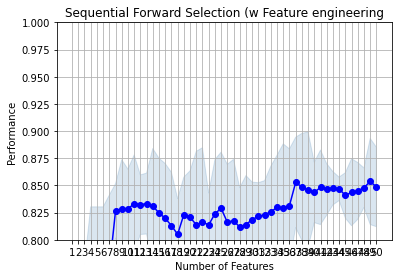

In [53]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(selector.get_metric_dict(), kind='std_dev')

plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w Feature engineering')
plt.grid()
plt.show()

In [63]:
knntop_50_features = list(selector.k_feature_names_)
print(top_50_features)

[4, 7, 14, 30, 33, 46, 49, 65, 67, 82, 90, 92, 95, 98, 100, 111, 115, 117, 120, 145, 147, 167, 207, 239, 260, 266, 272, 280, 286, 301, 312, 315, 318, 320, 331, 343, 347, 350, 351, 352, 353, 354, 355, 356, 358, 359, 360, 361, 362]


In [26]:
knntop_50_features = [4, 7, 14, 30, 33, 46, 49, 65, 67, 82, 90, 92, 95, 98, 100, 111, 115, 117, 120, 145, 147, 167, 207, 239, 260, 266, 272, 280,
286, 301, 312, 315, 318, 320, 331, 343, 347, 350, 351, 352, 353, 354, 355, 356, 358, 359, 360, 361, 362]

In [65]:
df_Xtrain[knntop_50_features]

,4,7,14,30,33,46,49,65,67,82,90,92,95,98,100,111,115,117,120,145,147,167,207,239,260,266,272,280,286,301,312,315,318,320,331,343,347,350,351,352,353,354,355,356,358,359,360,361,362
0,1.265232,0.210682,0.910638,1.162883,0.512526,0.793763,0.665237,-0.788053,-1.550872,-0.344336,-1.736100,0.225435,0.728730,-1.531314,1.468849,0.073237,-0.881364,0.655132,0.654168,1.376506,-0.365603,-0.266514,-0.613266,-0.141287,-0.691782,-0.642604,-1.567094,0.567860,-1.730588,2.199155,0.405400,-2.669691,1.662065,-0.194407,0.881744,2.215470,0.238977,0.019203,-0.420092,0.009127,-0.304520,-0.007789,0.0,0.0,-0.094597,-0.308239,-0.052148,-0.199788,-0.062845
1,-0.415729,0.291718,0.648998,-0.177127,-2.552011,-0.919554,0.139402,1.239630,1.107783,0.532991,-0.034617,0.158651,0.709356,-0.278322,-1.173640,-2.213574,-0.344619,0.913468,0.577267,0.955828,-0.392937,-1.244608,0.359065,0.424232,0.972249,0.968584,-0.592264,-0.000182,1.624629,-0.385008,0.049875,0.285470,-0.404664,1.565099,0.500674,-0.354507,-0.435627,0.845597,0.159230,0.339479,-0.097150,0.108878,0.0,0.0,0.212457,-0.233884,-0.015774,-0.189851,-0.059039
2,-0.022827,-0.267006,1.201470,-1.966120,1.044330,-1.528443,-1.481126,0.956508,0.563348,-0.032919,0.716311,-1.328812,0.964440,0.101281,-0.853875,0.790955,-0.796466,-0.365154,0.395502,-0.980484,1.259268,1.164026,-1.088473,0.035503,-0.549755,-0.872484,0.248040,-1.076888,1.272643,0.288191,0.611449,-0.205832,0.173637,0.283863,0.790801,0.230399,-0.082776,0.047544,-0.414008,0.010260,-0.304293,-0.007748,0.0,0.0,-0.008566,-0.326120,-0.047334,-0.200821,-0.062606
3,-0.433148,0.805660,1.150656,1.038001,0.521405,1.354503,-0.892191,-0.722874,1.607856,2.142540,-0.628326,-1.679934,-1.150494,-2.260473,-0.484114,-0.492516,-0.558751,-0.148787,0.566281,0.243759,-1.186644,0.009020,0.641998,0.570006,-0.089427,0.354895,2.567161,1.801915,0.931066,-1.537754,-2.044814,1.654924,-1.136002,1.410626,0.814392,-1.451333,-0.211973,0.911280,0.221509,0.384446,-0.062832,0.131700,0.0,0.0,1.986491,1.326695,1.096022,0.608761,0.475143
4,1.183942,1.525391,-1.508995,-0.257409,0.169171,0.191896,0.381286,0.359712,-0.177687,0.019542,-1.975032,0.645365,0.164747,0.777356,0.792864,-0.664622,1.511821,0.950773,0.138833,-1.327568,-1.284844,0.461465,-0.153999,0.070654,-1.063469,0.295146,-0.541573,-1.853739,0.026501,-1.499406,-0.778252,1.566080,-0.954792,2.006260,1.678423,-1.287762,-0.110262,3.157238,3.016428,3.066935,2.691005,2.622240,0.0,0.0,0.773833,0.153307,0.196761,-0.073808,-0.000635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,1.576844,-0.778815,-2.008490,-1.512182,-1.264432,0.929184,0.461595,-0.339946,0.100579,0.797528,-1.083434,-0.221816,-0.291605,-0.543744,0.309570,0.412871,-0.398388,-3.989318,-2.158203,0.180110,-0.504299,0.059857,-1.249864,0.208156,1.593743,1.138716,0.366969,1.848427,0.272512,2.000086,-0.488998,-1.277730,2.874886,-0.198728,0.645347,2.006133,4.478578,0.006020,-0.417595,0.008753,-0.304458,-0.007798,0.0,0.0,0.553088,-0.016006,0.094560,-0.134534,-0.033580
246,0.810395,-0.078277,-0.009428,0.344208,0.133652,-1.477284,0.093511,-1.041640,-0.838066,-0.323129,-0.544545,-0.586093,1.024713,1.169980,-1.352792,-1.259668,0.781697,1.589618,1.578974,-0.832302,-0.264365,1.257565,0.670889,0.052044,0.354785,1.196439,-1.647031,-0.283213,-0.073796,-0.542099,0.707766,0.279451,-0.805426,0.186990,0.087835,-0.596169,-0.982364,0.027527,-0.419106,0.009257,-0.304504,-0.007787,0.0,0.0,-0.021674,-0.328139,-0.047595,-0.200856,-0.062610
247,1.579747,1.645879,-1.211676,2.025168,0.108985,-0.026783,-0.490644,-0.198385,1.530224,-0.244995,0.026409,-0.076105,1.363748,-0.805160,2.080257,0.402801,-0.066341,-1.212906,-0.518319,-0.447426,0.592109,0.735983,0.181734,1.162405,-1.156139,0.987826,0.957716,0.170032,1.347393,1.035149,-0.013360,-1.069955,0.941369,-1.369209,-0.836117,1.077625,0.355626,-0.837388,0.189587,-0.342990,-0.080641,-0.135361,0.0,0.0,-0.290377,-0.214

In [66]:
knn_model = KNeighborsClassifier(**knn_clf.best_params_)
knn_model.fit(df_Xtrain[knntop_50_features],y_train)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=49)

In [67]:
y_pred = knn_model.predict(df_Xtrain[knntop_50_features])
print(y_pred)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]


In [ ]:
train_auc = roc_auc_score(y_train,y_pred)
print(train_auc)

0.54375


In [ ]:
y_predict = knn_model.predict_proba(df_Xtest[knntop_50_features])[:,1]

In [ ]:
y_pred_lr_test = pd.DataFrame({"ID": df_test['id'],"Target": y_predict})


y_pred_lr_test.to_csv('submission_knn_features.csv', index=False)  
y_pred_lr_test.head(20)

,ID,Target
0,250,0.489796
1,251,0.693878
2,252,0.571429
3,253,0.653061
4,254,0.551020
5,255,0.489796
6,256,0.612245
7,257,0.673469
8,258,0.693878
9,259,0.673469


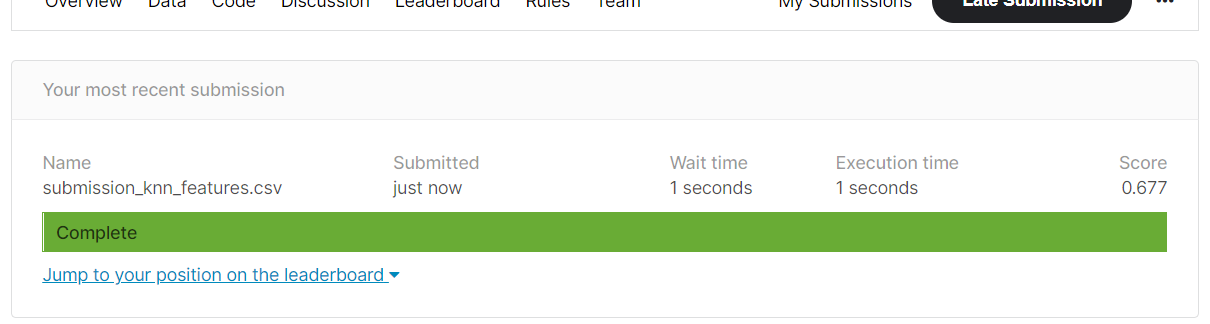

test_auc = 0.677

**Let's take top 100 features**

In [68]:
knn= KNeighborsClassifier()
#refhttps://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html
selector = SequentialFeatureSelector(knn,k_features=(10, 100),forward=True,cv=5,scoring='roc_auc')
selector.fit(X_train,y_train)

SequentialFeatureSelector(estimator=KNeighborsClassifier(),
                          k_features=(10, 100), scoring='roc_auc')

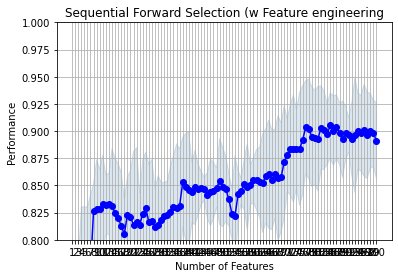

In [69]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(selector.get_metric_dict(), kind='std_dev')

plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w Feature engineering')
plt.grid()
plt.show()

In [71]:
knntop_100_features = list(selector.k_feature_names_)
print(knntop_100_features)

['4', '5', '7', '14', '30', '33', '46', '48', '49', '60', '65', '67', '68', '69', '73', '75', '80', '82', '90', '92', '95', '98', '100', '111', '114', '115', '116', '117', '120', '140', '145', '147', '161', '163', '167', '168', '171', '172', '193', '195', '202', '207', '217', '224', '239', '253', '260', '266', '272', '280', '282', '286', '295', '297', '300', '301', '305', '306', '309', '310', '312', '315', '316', '317', '318', '320', '329', '331', '343', '344', '347', '349', '350', '351', '352', '353', '354', '355', '356', '357', '358', '359', '360', '361', '362']


In [27]:
knntop_100_features = [4, 5, 7, 14, 30, 33, 46, 48, 49, 60, 65, 67, 68, 69, 73, 75, 80, 
                82, 90, 92, 95, 98, 100, 111, 114, 115, 116, 117, 120, 140, 145, 147, 
                161, 163, 167, 168, 171, 172, 193, 195, 202, 207, 217, 224, 239, 253,
                260, 266, 272, 280, 282, 286, 295, 297, 300, 301, 305, 306, 309, 310,
                312, 315, 316, 317, 318, 320, 329, 331, 343, 344, 347, 349, 350, 351, 
                352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362]

In [ ]:
knn_model = KNeighborsClassifier(**knn_clf.best_params_)
knn_model.fit(df_Xtrain[knntop_100_features],y_train)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=49)

In [ ]:
y_pred = knn_model.predict(df_Xtrain[knntop_100_features])
print(y_pred)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]


In [ ]:
train_auc = roc_auc_score(y_train,y_pred)
print(train_auc)

0.5381944444444444


In [ ]:
y_predict = knn_model.predict_proba(df_Xtest[knntop_100_features])[:,1]
print(y_predict)

[0.53061224 0.69387755 0.71428571 ... 0.73469388 0.65306122 0.57142857]


In [ ]:
y_pred_lr_test = pd.DataFrame({"ID": df_test['id'],"Target": y_predict})


y_pred_lr_test.to_csv('submission_knn_top100features.csv', index=False)  
y_pred_lr_test.head(20)

,ID,Target
0,250,0.530612
1,251,0.693878
2,252,0.714286
3,253,0.693878
4,254,0.612245
5,255,0.591837
6,256,0.612245
7,257,0.612245
8,258,0.755102
9,259,0.591837


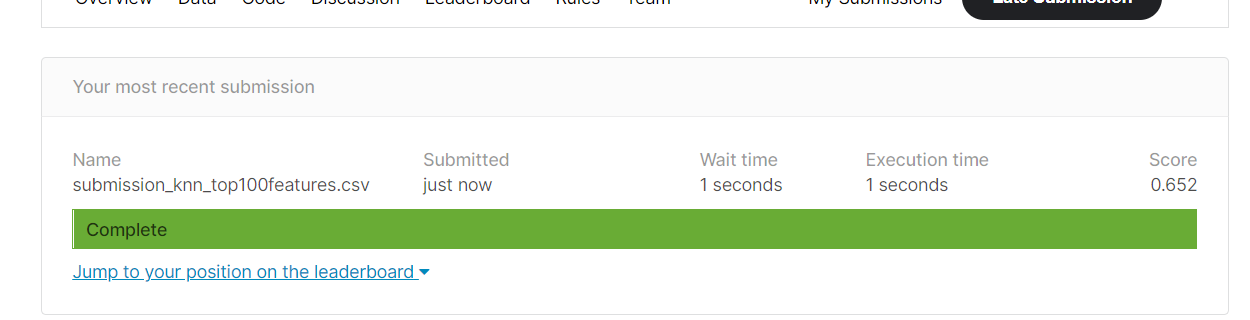

**Logistic Regresstion Applied**

In [20]:
#ref= https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

params = {'penalty':['l1','l2','elasticnet'],'C':[10**i for i in range(-4,5)], 'solver':['liblinear','sag','saga']}

#the instance  of Logistic Regression

log_model = LogisticRegression(random_state=42)

#Call Hyper-parameter function to get best hyperparameter tuning

log_clf = hyperparameter_model(log_model,params)



In [74]:
selector = SequentialFeatureSelector(log_model,k_features=(10, 50),forward=True,cv=5,scoring='roc_auc')
selector.fit(X_train,y_train)

SequentialFeatureSelector(estimator=LogisticRegression(random_state=42),
                          k_features=(10, 50), scoring='roc_auc')

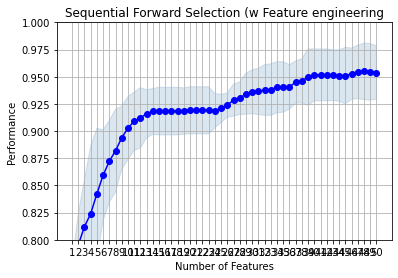

In [75]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(selector.get_metric_dict(), kind='std_dev')

plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w Feature engineering')
plt.grid()
plt.show()

In [76]:
logistictop_50_features = list(selector.k_feature_names_)
print(top_50_features)

[4, 7, 14, 30, 33, 46, 49, 65, 67, 82, 90, 92, 95, 98, 100, 111, 115, 117, 120, 145, 147, 167, 207, 239, 260, 266, 272, 280, 286, 301, 312, 315, 318, 320, 331, 343, 347, 350, 351, 352, 353, 354, 355, 356, 358, 359, 360, 361, 362]


In [28]:
logistictop_50_features =  [4, 7, 13, 16, 24, 33, 49, 51, 64, 65, 67, 73, 90, 91, 
                     104, 114, 116, 117, 123, 143, 149, 156, 164, 183, 188, 192, 217, 221, 226, 228, 253, 256, 
                     260, 268, 302, 311, 313, 328, 330, 337, 338, 339, 355, 356, 358, 360, 361, 362]

In [ ]:
print(log_clf.best_params_)

{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [ ]:
from sklearn import linear_model

model = LogisticRegression(penalty='l1', C=1, solver='saga')

model.fit(df_Xtrain[top_50_features],y_train)

LogisticRegression(C=1, penalty='l1', solver='saga')

In [ ]:
y_pred = model.predict(df_Xtrain[logistictop_50_features])
print(y_pred)

[1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0.
 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.
 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.]


In [ ]:
train_auc_lr = roc_auc_score(y_train,y_pred)
print(train_auc_lr)

0.9027777777777778


In [ ]:
y_pred_lr_test = model.predict_proba(df_Xtest[logistictop_50_features])[:,1]
print(y_pred_lr_test)

[0.0445232  0.33663622 0.80638496 ... 0.53660329 0.99484058 0.12661038]


In [ ]:
y_pred_lr_test = pd.DataFrame({"ID": df_test['id'],"Target": y_pred_lr_test})


y_pred_lr_test.to_csv('submission_logs_50features.csv', index=False)  
y_pred_lr_test.head(20)

,ID,Target
0,250,0.044523
1,251,0.336636
2,252,0.806385
3,253,0.932935
4,254,0.138762
5,255,0.101394
6,256,0.280308
7,257,0.028632
8,258,0.872992
9,259,0.096193


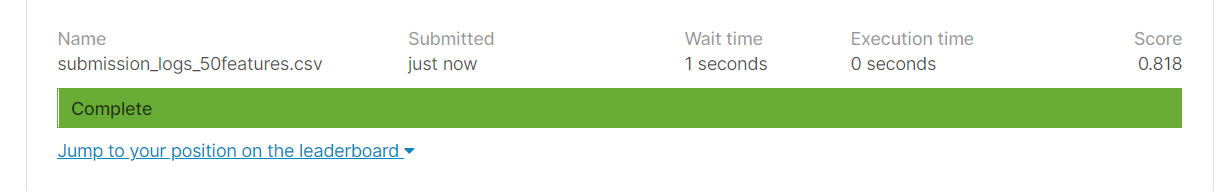

logistic_test_auc = 0.818

**Let's take top 100 features**

In [21]:
selector = SequentialFeatureSelector(log_model,k_features=(10, 100),forward=True,cv=5,scoring='roc_auc')
selector.fit(X_train,y_train)

SequentialFeatureSelector(estimator=LogisticRegression(random_state=42),
                          k_features=(10, 100), scoring='roc_auc')

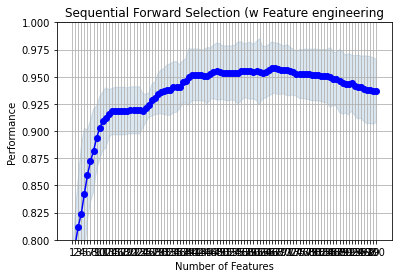

In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(selector.get_metric_dict(), kind='std_dev')

plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w Feature engineering')
plt.grid()
plt.show()

In [ ]:
logistictop_100_features = list(selector.k_feature_names_)
print(top_100_features)

['4', '7', '13', '16', '21', '24', '33', '49', '51', '61', '64', '65', '67', '73', '79', '90', '91', '104', '105', '114', '116', '117', '123', '129', '135', '143', '149', '156', '161', '164', '183', '188', '192', '196', '199', '213', '217', '221', '226', '228', '253', '256', '260', '265', '268', '269', '274', '279', '285', '302', '311', '313', '319', '320', '328', '330', '337', '338', '339', '355', '356', '358', '359', '360', '361', '362']


In [29]:
logistictop_100_features = [4, 7, 13, 16, 21, 24, 33, 49, 51, 61, 64, 65, 67, 73,
                    79, 90, 91, 104, 105, 114, 116, 117, 123, 129, 135, 143,
                    149, 156, 161, 164, 183, 188, 192, 196, 199, 213, 217, 221, 
                    226, 228, 253, 256, 260, 265, 268, 269, 274, 279, 285, 302,
                    311, 313, 319, 320, 328, 330, 337, 338, 339, 355, 356, 358, 
                    359, 360, 361, 362]

In [ ]:
from sklearn import linear_model

model = LogisticRegression(penalty='l1', C=1, solver='saga')

model.fit(df_Xtrain[logistictop_100_features],y_train)

LogisticRegression(C=1, penalty='l1', solver='saga')

In [ ]:
y_pred = model.predict(df_Xtrain[logistictop_100_features])
print(y_pred)

[1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0.
 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.
 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0.
 0. 1. 1. 0. 0. 1. 0. 0. 1. 0.]


In [ ]:
train_lr_auc = roc_auc_score(y_train,y_pred)
print(train_lr_auc)

0.9392361111111113


In [ ]:
y_predict = model.predict_proba(df_Xtest[logistictop_100_features])[:,1]
print(y_predict)

[0.06088335 0.38840025 0.65453023 ... 0.38744559 0.99585269 0.25010157]


In [ ]:
y_pred_lr_test_100 = pd.DataFrame({"ID": df_test['id'],"Target": y_predict})


y_pred_lr_test_100.to_csv('submission_logs_100features.csv', index=False)  
y_pred_lr_test_100.head(20)

,ID,Target
0,250,0.060883
1,251,0.388400
2,252,0.654530
3,253,0.981406
4,254,0.044851
5,255,0.105564
6,256,0.366869
7,257,0.018923
8,258,0.892434
9,259,0.117482


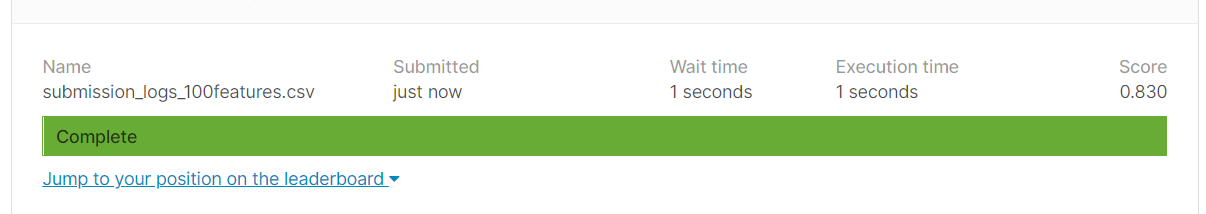

test_logistic_auc = 0.83

**Support Vector Machine**

In [38]:
from sklearn.svm import SVC

In [ ]:
#ref = https://scikit-learn.org/stable/modules/svm.html

params = {'C':[10**i for i in range(-4,5)],'kernel':['linear','poly','sigmoid','rdf']}

#The instance of SVC

svc_model = SVC(random_state=42)
#call the hyper-parameter function to get best parameters

svc_clf = hyperparameter_model(svc_model,params)

In [ ]:
print(svc_clf.best_params_)

{'C': 0.1, 'kernel': 'linear'}


In [ ]:
selector = SequentialFeatureSelector(svc_model,k_features=(10, 50),forward=True,cv=5,scoring='roc_auc')
selector.fit(X_train,y_train)

SequentialFeatureSelector(estimator=SVC(random_state=42), k_features=(10, 50),
                          scoring='roc_auc')

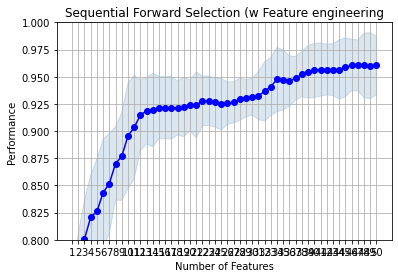

In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(selector.get_metric_dict(), kind='std_dev')

plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w Feature engineering')
plt.grid()
plt.show()

In [ ]:
svctop_50_features = list(selector.k_feature_names_)
print(top_50_features)

['9', '28', '31', '33', '45', '46', '62', '65', '66', '68', '73', '80', '91', '95', '100', '114', '123', '131', '132', '133', '141', '146', '159', '168', '169', '181', '194', '195', '217', '226', '233', '249', '253', '258', '264', '272', '282', '288', '304', '350', '354', '355', '356', '358', '359', '362']


In [23]:
svctop_50_features = [9, 28, 31, 33, 45, 46, 62, 65, 66, 68,
                    73, 80, 91, 95, 100, 114, 123, 131, 132, 
                    133, 141, 146, 159, 168, 169, 181, 194, 195,
                    217, 226, 233, 249, 253, 258, 264, 272, 282,
                    288, 304, 350, 354, 355, 356, 358, 359, 362]

In [ ]:
from sklearn import linear_model

model = SVC(C=0.1, kernel='linear',probability=True)

model.fit(df_Xtrain[svctop_50_features],y_train)

SVC(C=0.1, kernel='linear', probability=True)

In [ ]:
y_pred = model.predict(df_Xtrain[svctop_50_features])
print(y_pred)

[1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1.
 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1.
 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1.
 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.]


In [ ]:
train_svc_auc = roc_auc_score(y_train,y_pred)
print(train_svc_auc)

0.8798611111111111


In [ ]:
y_pred_svc = model.predict_proba(df_Xtest[svctop_50_features])[:,1]
print(y_pred_svc)

[0.14506099 0.4656034  0.92775101 ... 0.86146204 0.91354606 0.65519584]


In [ ]:
y_pred_svc_test_50 = pd.DataFrame({"ID": df_test['id'],"Target": y_pred_svc})


y_pred_svc_test_50.to_csv('submission_svc50features.csv', index=False)  
y_pred_svc_test_50.head(20)

,ID,Target
0,250,0.145061
1,251,0.465603
2,252,0.927751
3,253,0.896267
4,254,0.653264
5,255,0.630216
6,256,0.500000
7,257,0.160114
8,258,0.903210
9,259,0.086692


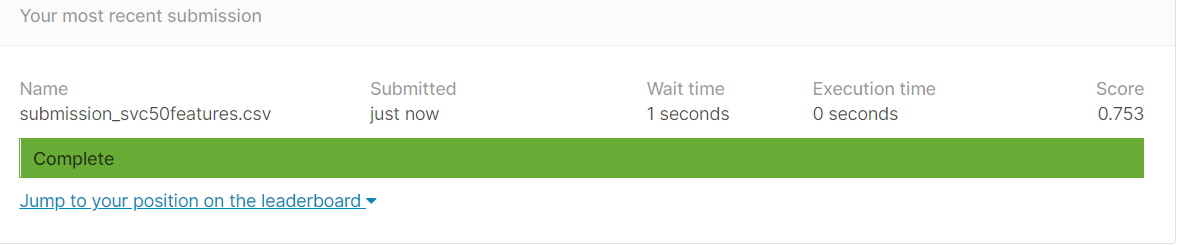

Test_SVM_auc = 0.753

**Let's take top 100 features**

In [ ]:
selector = SequentialFeatureSelector(svc_model,k_features=(10, 100),forward=True,cv=5,scoring='roc_auc')
selector.fit(X_train,y_train)

SequentialFeatureSelector(estimator=SVC(random_state=42), k_features=(10, 100),
                          scoring='roc_auc')

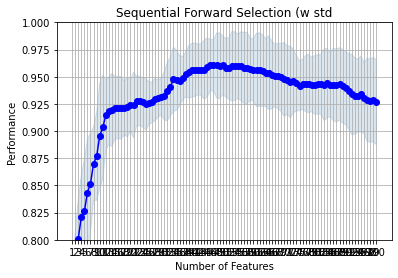

In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(selector.get_metric_dict(), kind='std_dev')

plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w std')
plt.grid()
plt.show()

In [ ]:
svctop_100_features = list(selector.k_feature_names_)
print(top_100_features)

['9', '28', '31', '33', '45', '46', '62', '65', '66', '68', '73', '80', '91', '95', '100', '114', '123', '131', '132', '133', '141', '146', '159', '168', '169', '181', '194', '195', '217', '226', '233', '249', '253', '258', '264', '272', '282', '288', '304', '350', '354', '355', '356', '358', '359', '362']


In [24]:
svctop_100_features = [9, 28, 31, 33, 45, 46, 62, 65, 66, 68,
                    73, 80, 91, 95, 100, 114, 123, 131, 132, 
                    133, 141, 146, 159, 168, 169, 181, 194, 195,
                    217, 226, 233, 249, 253, 258, 264, 272, 282,
                    288, 304, 350, 354, 355, 356, 358, 359, 362]

In [ ]:
from sklearn import linear_model

model = SVC(C=0.1, kernel='linear',probability=True)

model.fit(df_Xtrain[svctop_100_features],y_train)

SVC(C=0.1, kernel='linear', probability=True)

In [ ]:
y_pred = model.predict(df_Xtrain[svctop_100_features])
print(y_pred)

[1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1.
 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1.
 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1.
 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.]


In [ ]:
train_svc_auc_100features = roc_auc_score(y_train,y_pred)
print(train_svc_auc_100features)

0.8798611111111111


In [ ]:
y_pred_svc_top100 = model.predict_proba(df_Xtest[svctop_100_features])[:,1]


In [ ]:
y_pred_svc_test_100 = pd.DataFrame({"ID": df_test['id'],"Target": y_pred_svc_top100})


y_pred_svc_test_100.to_csv('submission_svc100features.csv', index=False)  
y_pred_svc_test_100.head(10)

,ID,Target
0,250,0.167671
1,251,0.500000
2,252,0.935021
3,253,0.906848
4,254,0.684161
5,255,0.660151
6,256,0.532745
7,257,0.184330
8,258,0.913066
9,259,0.101990


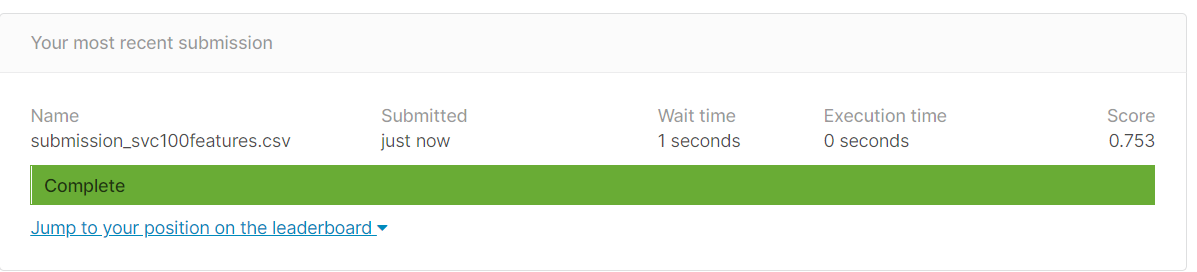

**Ensemble Model : Random Forest**

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
params = {'n_estimators': [10,20,30,40,50,60,100,200,300,400],'max_depth':[2,3,5,7,9]}

#The instance of model

rdf_model = RandomForestClassifier(random_state=42)

# Call the hyperparameter function  to get best parameter
rdf_clf = hyperparameter_model(rdf_model,params)


In [ ]:
selector = SequentialFeatureSelector(rdf_model,k_features=(10, 15),forward=True,cv=5,scoring='roc_auc')
selector.fit(X_train,y_train)

SequentialFeatureSelector(estimator=RandomForestClassifier(random_state=42),
                          k_features=(10, 15), scoring='roc_auc')

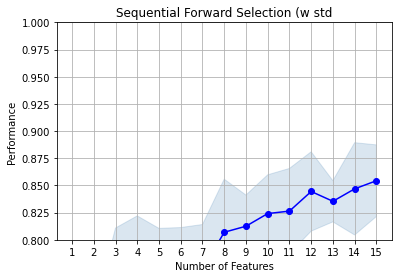

In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(selector.get_metric_dict(), kind='std_dev')

plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w std')
plt.grid()
plt.show()

In [ ]:
rdftop_15_features = list(selector.k_feature_names_)
print(top_15_features)

['2', '17', '33', '45', '65', '96', '116', '194', '199', '214', '215', '217', '315', '317', '320']


In [31]:
rdftop_15_features = [2, 17, 33, 45, 65, 96, 116, 194, 199, 214, 215, 217, 315, 317, 320]

In [ ]:
df_Xtrain[rdftop_15_features]

,2,17,33,45,65,96,116,194,199,214,215,217,315,317,320
0,0.503692,-0.560123,0.512526,0.807873,-0.788053,1.142777,-0.294448,-0.306051,1.730666,-0.505591,0.810781,1.128962,-2.669691,-0.025449,-0.194407
1,-0.539790,-0.128760,-2.552011,-1.184575,1.239630,-1.454985,0.651431,0.014025,-2.250726,-0.028172,0.318050,0.171834,0.285470,0.822779,1.565099
2,-0.505465,0.372848,1.044330,0.951000,0.956508,-1.749053,0.076352,-0.589873,0.354049,-0.084865,0.295837,0.224076,-0.205832,0.794897,0.283863
3,0.220265,0.932829,0.521405,-0.936420,-0.722874,-1.118907,0.428757,-1.006283,1.126227,0.470135,1.409531,0.023977,1.654924,1.634976,1.410626
4,0.336970,-0.212856,0.169171,0.304356,0.359712,0.520447,0.037626,0.070997,0.157389,0.060350,1.964863,0.067348,1.566080,2.508765,2.006260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,-1.054666,-0.952901,-1.264432,-1.099111,-0.339946,1.409489,-2.046792,0.159044,0.135217,0.362716,0.174673,0.178734,-1.277730,-1.048334,-0.198728
246,-0.536848,-0.208898,0.133652,-1.393602,-1.041640,-0.072573,-0.445479,0.652106,0.577701,0.765539,-0.892575,1.526205,0.279451,0.600351,0.186990
247,-0.047471,0.256103,0.108985,0.366137,-0.198385,0.045640,-0.412562,-0.844691,0.060024,-1.304275,-1.052107,1.159519,-1.069955,-1.538929,-1.369209
248,0.016276,-0.249462,-0.488925,-0.368031,-0.383738,-0.503417,0.076352,-1.472413,-0.394993,0.300054,0.613891,-1.203237,-0.097842,1.176346,0.580379


In [ ]:
print(rdf_clf.best_params_)

{'max_depth': 9, 'n_estimators': 400}


In [ ]:
rdf_clf = RandomForestClassifier(**rdf_clf.best_params_,bootstrap=True)
rdf_clf.fit(df_Xtrain[rdftop_15_features],y_train)

RandomForestClassifier(max_depth=9, n_estimators=400)

In [ ]:
y_pred = rdf_clf.predict(df_Xtrain[rdftop_15_features])
train_rdf_auc = roc_auc_score(y_train,y_pred)
print(train_rdf_auc)

1.0


In [ ]:
y_pred_rdf_test = rdf_clf.predict_proba(df_Xtest[rdftop_15_features])[:,1]

In [ ]:
y_pred_rdf_test = pd.DataFrame({"ID": df_test['id'],"Target": y_pred_rdf_test})


y_pred_rdf_test.to_csv('submission_rdf_top15.csv', index=False)  
y_pred_rdf_test.head(20)

,ID,Target
0,250,0.534700
1,251,0.777835
2,252,0.562941
3,253,0.862542
4,254,0.489986
5,255,0.412787
6,256,0.396291
7,257,0.673244
8,258,0.932938
9,259,0.536302


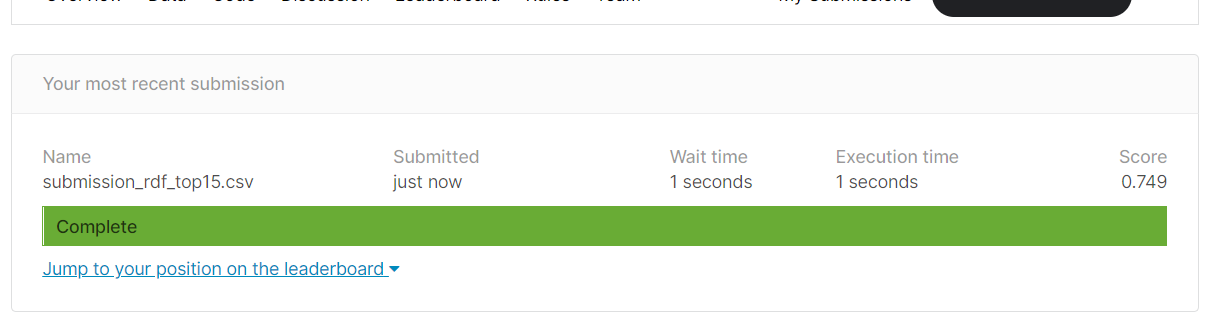

Test_rdf_auc : 0.75

**XGBoost Classifier**

In [39]:
from xgboost import XGBClassifier

In [20]:
#list of hyper-parameter

params = {'max_depth':[2,3,5,7,9],'n_estimators':[10,20,30,40,50,100,200,400,500]}

# The instance of XGBClassifier

xg_model = XGBClassifier()
# call hyparameter function to get best parameter

xg_clf = hyperparameter_model(xg_model,params)

In [23]:
print(xg_clf.best_params_)

{'max_depth': 9, 'n_estimators': 500}


In [22]:
selector = SequentialFeatureSelector(xg_model,k_features=(10, 50),forward=True,cv=5,scoring='roc_auc')
selector.fit(X_train,y_train)

SequentialFeatureSelector(estimator=XGBClassifier(), k_features=(10, 50),
                          scoring='roc_auc')

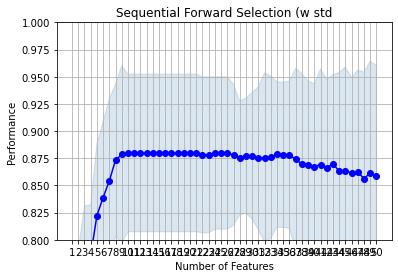

In [24]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(selector.get_metric_dict(), kind='std_dev')

plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w std')
plt.grid()
plt.show()

In [25]:
xgboottop_50_features = list(selector.k_feature_names_)
print(top_50_features)

['33', '50', '65', '91', '164', '167', '230', '301', '361', '362']


In [30]:
xgboottop_50_features = [33, 50, 65, 91, 164, 167, 230, 301, 361, 362]

In [27]:
xg_clf = XGBClassifier(**xg_clf.best_params_)
xg_clf.fit(df_Xtrain[xgboottop_50_features],y_train)

XGBClassifier(max_depth=9, n_estimators=500)

In [31]:
y_pred = xg_clf.predict(df_Xtrain[xgboottop_50_features])
train_auc = roc_auc_score(y_train,y_pred)
print(train_auc)

1.0


In [32]:
y_pred_xg_test = xg_clf.predict_proba(df_Xtest[xgboottop_50_features])[:,1]
print(y_pred_xg_test)

[0.29076236 0.2061423  0.01131213 ... 0.89664805 0.99611    0.26628968]


In [33]:
y_pred_xg_test = pd.DataFrame({"ID": df_test['id'],"Target": y_pred_xg_test})


y_pred_xg_test.to_csv('submission_xgboosttop50.csv', index=False)  
y_pred_xg_test.head(10)

,ID,Target
0,250,0.290762
1,251,0.206142
2,252,0.011312
3,253,0.998524
4,254,0.536212
5,255,0.089159
6,256,0.140542
7,257,0.136743
8,258,0.999746
9,259,0.004194


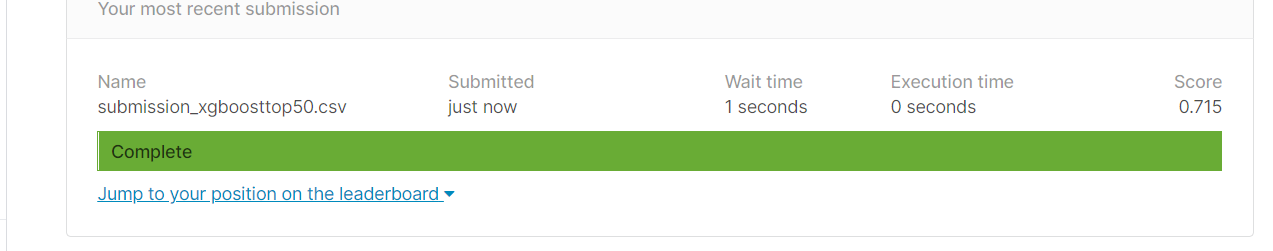

xgboost_test_auc = 0.715

**Stacking Classifier**

In [32]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [33]:
from mlxtend.classifier import StackingClassifier

In [57]:
# Combined all top features of all models
# Ref: https://www.geeksforgeeks.org/union-function-python/

all_top_feat = logistictop_50_features+knntop_100_features+svctop_50_features+xgboottop_50_features

In [61]:
#classifier 1
knn_model = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=49)
knn_model.fit(X_train[:,all_top_feat],y_train)

#Classifier 2
model = LogisticRegression(penalty='l1', C=1, solver='saga')
model.fit(X_train[:,all_top_feat],y_train)

#Classifier 3
svc_clf = SVC(C =0.1, kernel = 'linear',probability=True)
svc_clf.fit(X_train[:,all_top_feat],y_train)

#classifier 3

rdf_clf = RandomForestClassifier(max_depth=9, n_estimators=400)
rdf_clf.fit(X_train[:,all_top_feat],y_train)



#classifier 5
xg_clf = XGBClassifier(max_depth = 9, n_estimators = 500)
xg_clf.fit(X_train[:,all_top_feat],y_train)


#Stacking Classifer

sclf = StackingClassifier(classifiers=[knn_model,model,svc_clf,rdf_clf,xg_clf],meta_classifier=model,use_probas=True)

#fit the model
sclf.fit(X_train[:,all_top_feat],y_train)

#predict in probabilities

y_pred = sclf.predict(X_train[:,all_top_feat])


In [62]:
train_auc = roc_auc_score(y_train,y_pred)
print(train_auc)

1.0


In [66]:
y_pred_stack_test = sclf.predict_proba(X_test[:,all_top_feat])[:,1]
print(y_pred_stack_test)

[0.12189521 0.98701918 0.96373052 ... 0.25666822 0.99342974 0.78469862]


In [64]:
y_pred_stack_test = pd.DataFrame({"ID": df_test['id'],"Target": y_pred_stack_test})


y_pred_stack_test.to_csv('submission_stack_top50features.csv', index=False)  
y_pred_stack_test.head(20)

,ID,Target
0,250,0.121895
1,251,0.987019
2,252,0.963731
3,253,0.993992
4,254,0.776488
5,255,0.991428
6,256,0.239680
7,257,0.051843
8,258,0.993739
9,259,0.099150


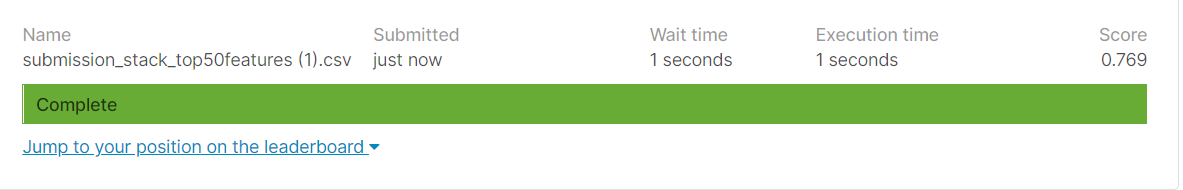

### Summary of All Models Using Top 50 Features

In [2]:
from texttable import Texttable
t = Texttable()
t.add_rows([['Model','Hyper-parameter','Train AUC','Test AUC'],['Knn_Model',r"(algorithm='kd_tree', n_neighbors=49)",0.54,0.68],
           ['logistic Regresstion',r"(C=1, penalty='l1', solver='saga')",0.90,0.82],['Support Vector Machine',
           r"{'C': 0.1, 'kernel': 'linear'}",0.87,0.76],['XGBoost Classifier',r"{'max_depth': 9, 'n_estimators': 500}",1.00,0.76],
            ['Random forest',r"{'max_depth': 9, 'n_estimators': 400}",1.0,0.75],
            ['Calibrated Model',"--",1.00,0.77]])

print(t.draw())

+------------------------+------------------------------+-----------+----------+
|         Model          |       Hyper-parameter        | Train AUC | Test AUC |
+========================+==============================+===========+==========+
| Knn_Model              | (algorithm='kd_tree',        | 0.540     | 0.680    |
|                        | n_neighbors=49)              |           |          |
+------------------------+------------------------------+-----------+----------+
| logistic Regresstion   | (C=1, penalty='l1',          | 0.900     | 0.820    |
|                        | solver='saga')               |           |          |
+------------------------+------------------------------+-----------+----------+
| Support Vector Machine | {'C': 0.1, 'kernel':         | 0.870     | 0.760    |
|                        | 'linear'}                    |           |          |
+------------------------+------------------------------+-----------+----------+
| XGBoost Classifier     | {

### Observation

1. We have read the training and test dataset. After reading both of dataset, we got it know that test dataset is having more features compare to training dataset.
2. Applied Feature Engineering to came up new features.
3. Dropped the labled data from both train and test datasets.
4. Standradized the Features using StandardScaler method.
4. Used GridSerach Validation for hyper-parameter tuning.
5. We have applied following machine learning algorithm:
   1.KNN : The KNN algorithm trained the model with parameter(algorithm = 'kd_tree', and n_neighbors=49). Used forward Feature      selection Method and came up top 50 Feature based on performance. Re-train the model using KNN with best parameter and got      train_AUC=0.54 and Test Auc = 0.68 . Model is less accurate but it is not overfitted.
   
   2.Logistic Regression : The Logistic regression algorithm trained the model with                    parameter(C=1,penalty=l1,solver=saga). Used forward Feature selection Method and came up top 50 Feature based on performance. Re-traing the model with best parameter on top 50 Features and got train_AUC = 0.90 and Test_auc=0.82 which is working as expected.
   
   3.Support Vector Machine: The SVM algorithm trained the model with parameter(C=0.1,kernel=linear).Used forward Feature        selection Method and came up top 50 Feature based on performance.Re-train the model with best parameter on top 50 features      and got the train_AUC=0.87 and Test_AUC = 0.76.Model is not overfitted
   
   4.XGBoost Classifier: The XGBoost classifier trained the model with parameter(max_depth=9,n_estimators=500). Used forward        Feature selection Method and came up top 50 Feature based on performance.Re-train the model with best parameter on top 50        features and got the train_AUC= 1.0 and Test_AUC=0.76.Model is not overfitted.
   
   5.Random Forest : The Random Forest classifier trained the model with parameter(max_depth=9,n_estimators=400).Used forward      Feature  selection Method and came up top 50 Feature based on performance. Re-train the model on top 50 features and got the   train_AUC = 1.0 and test_AUC = 0.75.Model is not overfitted.
   
   7.Calibrated model gave train_AUC = 1.0 and Test_AUC = 0.77. Model is accurate and not overfitted.
 
Logistic Regression is working well from above applied algorithm.

#### Summary of All Models Using Top 100 Features

In [4]:
from texttable import Texttable
t = Texttable()
t.add_rows([['Model','Hyper-parameter','Train AUC','Test AUC'],['Knn_Model',r"(algorithm='kd_tree', n_neighbors=49)",0.54,0.65],
           ['logistic Regresstion',r"(C=1, penalty='l1', solver='saga')",0.93,0.83],['Support Vector Machine',
           r"{'C': 0.1, 'kernel': 'linear'}",0.88,0.75],['XGBoost Classifier',r"{'max_depth': 9, 'n_estimators': 500}",1.00,0.75]])

print(t.draw())

+------------------------+------------------------------+-----------+----------+
|         Model          |       Hyper-parameter        | Train AUC | Test AUC |
+========================+==============================+===========+==========+
| Knn_Model              | (algorithm='kd_tree',        | 0.540     | 0.650    |
|                        | n_neighbors=49)              |           |          |
+------------------------+------------------------------+-----------+----------+
| logistic Regresstion   | (C=1, penalty='l1',          | 0.930     | 0.830    |
|                        | solver='saga')               |           |          |
+------------------------+------------------------------+-----------+----------+
| Support Vector Machine | {'C': 0.1, 'kernel':         | 0.880     | 0.750    |
|                        | 'linear'}                    |           |          |
+------------------------+------------------------------+-----------+----------+
| XGBoost Classifier     | {

### Observation

1. We have read the training and test dataset. After reading both of dataset, we got it know that test dataset is having more features compare to training dataset.
2. Applied Feature Engineering to came up new features.
3. Dropped the labled data from both train and test datasets.
4. Standradized the Features using StandardScaler method.
4. Used GridSerach Validation for hyper-parameter tuning.
5. We have applied following machine learning algorithm:
   1.KNN : The KNN algorithm trained the model with parameter(algorithm = 'kd_tree', and n_neighbors=49). Used forward Feature      selection Method and came up top 100 Features based on performance. Re-train the model using KNN with best parameter and got      train_AUC=0.54 and Test Auc = 0.65 . Model is less accurate but it is not overfitted.
   
   2.Logistic Regression : The Logistic regression algorithm trained the model with                    parameter(C=1,penalty=l1,solver=saga). Used forward Feature selection Method and came up top 100 Features based on performance. Re-traing the model with best parameter on top 100 Features and got train_AUC = 0.93 and Test_auc=0.83 which is working as expected.
   
   3.Support Vector Machine: The SVM algorithm trained the model with parameter(C=0.1,kernel=linear).Used forward Feature        selection Method and came up top 100 Feature based on performance. Re-train the model with best parameter on top 100 features      and got the train_AUC=0.88 and Test_AUC = 0.75.Model is not overfitted
   
   4.XGBoost Classifier: The XGBoost classifier trained the model with parameter(max_depth=9,n_estimators=500). Used forward        Feature selection Method and came up top 100 Feature based on performance.Re-train the model with best parameter on top 100      features and got the train_AUC= 1.0 and Test_AUC=0.75.Model is not overfitted.

 
Logistic Regression is working well from above applied algorithm.